# Método Objetivo para Avaliação Quantitativa de Algoritmos de Pitch Shifting
---

### João Pedro Torres, Gabriel Barbosa da Fonseca

Instituto de Ciências Exatas e Informática

Pontifícia Universidade Católica de Minas Gerais (PUC Minas)

Caixa Postal 1.686 $-$ 30535.901 $-$ Belo Horizonte, MG $-$ Brasil

joao.silva@sga.pucminas.br, gabriel.fonseca.771248@sga.pucminas.br

## Dataset structure
---

- The dataset is composed by two directories: input and output.
- In the input folder, there is one .wav file for each major tonality (C, D, E, F, G, A and B).
- In the output folder, there is one subdirectory for each evaluated algorithm.
- Each algorithm subdirectory has 6 folders, each one for 2, 4, 6, 8, 10 and 12 semitons pitch shifting down
- Each pitch folder have the algorithm resultant .wav files each one of the the input files.

<pre>
/content/
├── input/
│   ├── C.wav
│   ├── D.wav
│   └── ... (original input .wav files)
├── output/
│   ├── algorithmA/
│   │   ├── pitch-x/
│   │   │   ├── C.wav
│   │   │   ├── D.wav
│   │   │   └── ... (-x semitons algorithmA shifted input .wav files)
│   │   └── ... (-n semitons algorithmA shift folders)
│   └── ... (algorithms shift folders)
└── metrics/
    ├── analytical/
    │   ├── C/
    │   │   ├── C.json
    │   │   ├── C.png
    │   │   └── ... (shifting analytical metrics)
    │   ├── D/
    │   │   ├── D.json
    │   │   ├── D.png
    │   │   └── ... (shifting analytical metrics)
    │   └── (input analytical folders)
    └── comparison/
        ├── C/
        │   ├── C.json
        │   ├── C.png
        │   └── ... (shifting comparison metrics)
        ├── D/
        │   ├── D.json
        │   ├── D.png
        │   └── ... (shifting comparison metrics)
        └── (input comparison folders)
</pre>

In [ ]:
import os
import json
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

import scipy.signal
import seaborn as sns
from sklearn.preprocessing import StandardScaler

!pip install torch torchaudio
import torch
import torchaudio
import math

import gc

!rm -rf /content/dataset
!unzip /content/dataset.zip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

## Prepare environment for evaluation
---

The dataset should be uncompressed and mapped, getting the environment to know the files that were processed, the plugins that were used to do it and the shifting ratios that were applied to the input processing and output generation.

In [ ]:
# ================================
# Paths
# ================================
input_dir = "/content/dataset/input"
output_dir = "/content/dataset/output"

spectrograms_dir = "/content/dataset/spectrograms"
analytical_dir = "/content/dataset/metrics/analytical"
comparison_dir = "/content/dataset/metrics/comparison"
results_dir = "/content/dataset/results"

# Create the directories
for d in [analytical_dir, comparison_dir, results_dir, spectrograms_dir]:
    os.makedirs(d, exist_ok=True)

# Discover inputs, plugins, ratios
input_files = sorted([
    f for f in os.listdir(input_dir)
    if f.endswith('.wav') and f != '.ipynb_checkpoints'
])
print(input_files)

plugins = sorted([
    p for p in os.listdir(output_dir)
    if os.path.isdir(os.path.join(output_dir, p)) and p != '.ipynb_checkpoints'
])
print(plugins)

all_ratios = sorted({
    r for p in plugins
    for r in os.listdir(os.path.join(output_dir, p))
    if os.path.isdir(os.path.join(output_dir, p, r)) and r != '.ipynb_checkpoints'
})
print(all_ratios)

['A.wav', 'B.wav', 'C.wav', 'D.wav', 'E.wav', 'F.wav', 'G.wav']
['elastiquepro', 'gxdetune', 'pitchoneoctavedown', 'pitchshifter2', 'rubberband', 'sox']
['pitch-02', 'pitch-04', 'pitch-06', 'pitch-08', 'pitch-10', 'pitch-12']


Plot the original and shifted audios' spectrograms

In [ ]:
# Tweak these for lower memory footprint:
SR               = 16000
MAX_AUDIO_DURATION = 20
HOP_LENGTH       = 1024
N_FFT            = 1024

def spectrogram(y, sr):
    S = np.abs(librosa.stft(y, n_fft=N_FFT, hop_length=HOP_LENGTH))
    return librosa.amplitude_to_db(S, ref=np.max)

for input_file in input_files:
    input_path = os.path.join(input_dir, input_file)
    if not os.path.exists(input_path):
        print(f"[Missing] {input_path}")
        continue

    y_input, _ = librosa.load(input_path, sr=SR, duration=MAX_AUDIO_DURATION)
    spec_input = spectrogram(y_input, SR)

    for plugin in plugins:
        num_ratios = len(all_ratios)
        total_plots = num_ratios + 1  # input + all ratio outputs

        fig, axes = plt.subplots(1, total_plots, figsize=(5 * total_plots, 4), constrained_layout=True)

        # --- Input subplot ---
        img_input = librosa.display.specshow(
            spec_input, sr=SR, hop_length=HOP_LENGTH,
            x_axis='time', y_axis='log', ax=axes[0]
        )
        axes[0].set_title(f'Input\n{input_file}')

        # --- Output subplots ---
        img_for_colorbar = None
        for i, ratio in enumerate(all_ratios):
            ax = axes[i + 1]
            output_path = os.path.join(output_dir, plugin, ratio, input_file)

            if os.path.exists(output_path):
                y_out, _ = librosa.load(output_path, sr=SR, duration=MAX_AUDIO_DURATION)
                spec_out = spectrogram(y_out, SR)

                img = librosa.display.specshow(
                    spec_out, sr=SR, hop_length=HOP_LENGTH,
                    x_axis='time', y_axis='log', ax=ax
                )
                ax.set_title(f'{plugin} | {ratio}')
                img_for_colorbar = img  # save for final colorbar

                del y_out, spec_out
            else:
                ax.text(
                    0.5, 0.5,
                    f'Missing:\n{plugin}\n{ratio}',
                    ha='center', va='center', fontsize=12
                )
                ax.axis('off')

            ax.set_yticks([])
            ax.set_ylabel('')

        # --- Tighter and well-positioned colorbar ---
        if img_for_colorbar:
            fig.colorbar(
                img_for_colorbar,
                ax=axes,
                location='right',
                format='%+2.0f dB',
                pad=0.02,     # smaller = closer to plots
                shrink=0.9    # height relative to plots
            )

        # Save and cleanup
        out_fname = f"{os.path.splitext(input_file)[0]}_{plugin}_all_ratios.png"
        out_path = os.path.join(spectrograms_dir, out_fname)
        plt.savefig(out_path, dpi=120)
        plt.close(fig)

        del fig, axes
        gc.collect()

    del y_input, spec_input
    gc.collect()


## Feature-Based Analysis of Individual Files
---

In order to analyze the results obtained from the input processing by the different algorithms implementations, there will be evaluated the input and output files in light of the following metrics.

- **Zero Crossing Rate**: Number of times the signal waveform crosses zero per frame, which is related to **noisiness and high-frequency** content.
- **Audio Energy**: Number of squared amplitude values, which measures **loudness and signal power**.
- **Spectrum Flatness Measure**: Ratio of geometric to arithmetic mean of the power spectrum, that aims to indicate the **relation between tonality and noisiness**.
- **Tonality**: Reflects how harmonic/tonal the signal is by detecting **artifactes and sound _"robotization"_**.
- **Harmonic Ratio**: Ratio of harmonic and total energy, which is sensitive to **phase distortion or time-scale modification side effects**.
- **Spectral Centroid**: It is the signal's "center of mass", which corresponds to **brightness** and helps to detect **tonal coloration**.
- **Mean Absolute Frequency Deviation**: For **spectral distortion** or _blurring_ quantification, as it measures the **frequencies deviation amplitude**.

In [ ]:
def analytical_metrics(audio, sr):
    zcr = np.mean(librosa.feature.zero_crossing_rate(audio))
    energy = np.sum(audio**2)
    sfm = np.mean(librosa.feature.spectral_flatness(y=audio))

    harmonic, _ = librosa.effects.hpss(audio)
    tonality = np.mean(np.abs(harmonic))

    harmonic_ratio = np.mean(librosa.yin(audio, fmin=librosa.note_to_hz('C0'), fmax=librosa.note_to_hz('C5')))

    centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr))

    frequencies = np.abs(np.diff(librosa.feature.spectral_centroid(y=audio, sr=sr)))
    mafd = np.mean(frequencies)

    frequencies, times, spectrogram = scipy.signal.spectrogram(audio, sr)
    peaks = scipy.signal.find_peaks(np.mean(spectrogram,axis=1))[0]

    return {
        'Zero Crossing Rate': zcr,
        'Audio Energy': energy,
        'Spectrum Flatness Measure': sfm,
        'Tonality': tonality,
        'Harmonic Ratio': harmonic_ratio,
        'Spectral Centroid': centroid,
        'Mean Absolute Frequency Deviation': mafd,
        'Number of Sinusoidal Peaks': len(peaks)
    }

## Similarity-Based Comparison Between Original and Shifted Files
---

For evaluating the pitch shifting performed for each algorithm implementation, the pairs of iput and output will be analyzed using the followinf methods:

- **MFCC L1 Distance**: For comparing the perceptual similarities between original and processed signals.
- **Loudness Distance**: For checking the preservation of envelope or dynamics before and after the processing.
- **Detuning**: For measuring pitch accuracy.
- **Cross-Correlation Max**: For assensing time-domain similarity despite pitch differences.
- **Drift Compensation**: For spotting latency artifacts or envelop timing issues.
- **Number of Sinusoidal Peaks**: For comparing the number of harmonic peaks in the spectrum, which checks timbre clarity and spectral integrity.
- **Phase Reset Distance**: For measuring abrupt phase changes.

In [ ]:
def comparative_metrics(a1, a2, sr, device=None):
    # initialize and cache on first call (or if sr/device changes)
    if not hasattr(comparative_metrics, 'initialized') \
       or comparative_metrics.sr != sr \
       or (device and comparative_metrics.device != device):
        # set device
        dev = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        comparative_metrics.device = dev
        comparative_metrics.sr = sr
        # MFCC transform
        comparative_metrics.mfcc_tf = torchaudio.transforms.MFCC(
            sample_rate=sr,
            n_mfcc=20,
            melkwargs={"n_fft": 2048, "hop_length": 512, "n_mels": 128, "window_fn": torch.hann_window}
        ).to(dev)
        # STFT window
        comparative_metrics.window = torch.hann_window(2048, device=dev)
        comparative_metrics.initialized = True

    dev = comparative_metrics.device
    mfcc_tf = comparative_metrics.mfcc_tf
    window = comparative_metrics.window

    # to tensor
    t1 = torch.as_tensor(a1, dtype=torch.float32, device=dev)
    t2 = torch.as_tensor(a2, dtype=torch.float32, device=dev)

    # align length
    n = min(t1.numel(), t2.numel())
    t1, t2 = t1[:n], t2[:n]

    # batched STFT for RMS & phase
    batch = torch.stack([t1, t2], dim=0)
    st = torch.stft(
        batch,
        n_fft=2048,
        hop_length=512,
        window=window,
        return_complex=True,
        center=True,
        pad_mode='reflect'
    )  # shape (2, freq, frames)
    mag2 = st.abs() ** 2
    # frame‑wise RMS
    rms = torch.sqrt(mag2.mean(dim=1))  # (2, frames)
    # phase
    phase = torch.angle(st)

    # MFCC (batch)
    mf = mfcc_tf(batch.unsqueeze(1))  # (2, n_mfcc, frames)
    m = mf.shape[-1]
    mfcc_dist = float((mf[0,:,:m] - mf[1,:,:m]).abs().mean().item())

    # loudness distance
    loud_dist = float((rms[0] - rms[1]).abs().mean().item())

    # detune: CPU fallback
    x1 = t1.detach().cpu().numpy()
    x2 = t2.detach().cpu().numpy()
    p1, _, _ = librosa.pyin(x1, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    p2, _, _ = librosa.pyin(x2, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    m3 = min(len(p1), len(p2))
    detune = np.nanmean(np.abs(p1[:m3] - p2[:m3]))

    # cross‑correlation via FFT (full mode)
    L = x1.size + x2.size - 1
    fsize = 1 << math.ceil(math.log2(L))
    A = torch.fft.rfft(t1, n=fsize)
    B = torch.fft.rfft(t2, n=fsize)
    cc = torch.fft.irfft(A * torch.conj(B), n=fsize)
    cc_max = float(cc.abs().max().item())

    # phase drift
    ph1, ph2 = phase[0], phase[1]
    mf2 = min(ph1.shape[1], ph2.shape[1])
    drift = float((ph1[:,:mf2] - ph2[:,:mf2]).abs().mean().item())
    drift = drift * ph1.numel() / ph1.shape[1] #drift / (ph1.numel())

    # phase reset distance
    def resets(sig):
        ana = scipy.signal.hilbert(sig)
        ip = np.unwrap(np.angle(ana))
        return np.where(np.diff(ip) > 0.1)[0] #np.where(np.diff(ip) > np.pi)[0]
    r1 = resets(x1)
    r2 = resets(x2)
    mr = abs(len(r1) - len(r2))>1 #min(len(r1), len(r2))
    pr_dist = float(np.mean(np.abs(r1[:mr] - r2[:mr]))) if mr > 0 else 0.0

    return {
        'MFCC L1 Distance':      mfcc_dist,
        'Loudness Distance':     loud_dist,
        'Detuning':              detune,
        'Cross-Correlation Max': cc_max,
        'Drift Compensation':    drift,
        'Phase Reset Distance':  pr_dist
    }

## Perform Metrics Calculation
---

The metrics defined above will be applied to all the output files. For each pair of input file and pitch shift will be generated a JSON file with results for each one of the algorithm implementation. Also, will be plot a graph per input file with the values for each one of the algorithms and their shifting ratios applied to the input.

In [ ]:
def make_json_serializable(x):
    if isinstance(x, dict): return {k: make_json_serializable(v) for k,v in x.items()}
    if isinstance(x, list): return [make_json_serializable(v) for v in x]
    if isinstance(x, np.ndarray): return x.tolist()
    if isinstance(x, (np.floating, np.integer)): return x.item()
    return x

# iterate over the input files
plugins_results, originals_metrics = {pl:[] for pl in plugins}, {}
for file_name in input_files:
    # get metrics for the original audio
    audio, sr = librosa.load(os.path.join(input_dir, file_name), sr=None)
    original_analytical = analytical_metrics(audio,sr)
    original_comparison = comparative_metrics(audio,audio,sr)
    originals_metrics[file_name] = {
        'analytical': original_analytical,
        'comparison': original_comparison
    }

    # ensure metric subfolders
    basename=os.path.splitext(file_name)[0]
    os.makedirs(os.path.join(analytical_dir,basename),exist_ok=True)
    os.makedirs(os.path.join(comparison_dir,basename),exist_ok=True)

    # iterate over the pitch ratios
    for ratio in all_ratios:
        analytical_dict = {
            'input_file': file_name,
            'pitch_ratio': ratio,
            'original': original_analytical,
            'shifted':{},
            'normalized':{}
        }
        comparison_dict = {
            'input_file': file_name,
            'pitch_ratio': ratio,
            'original': original_comparison,
            'shifted':{}
        }

        # iterate over the plugins
        for plugin in plugins:
            path = os.path.join(output_dir,plugin,ratio,file_name)
            if not os.path.exists(path): continue

            # get metrics for the shifted audio correspondent
            # to the input file, pitch ratio and plugin
            y, sr2 = librosa.load(path,sr=None)
            analytical_results = analytical_metrics(y,sr2)
            analytical_dict['shifted'][plugin] = analytical_results
            analytical_norm = {
                k: (
                    analytical_results[k]/original_analytical[k]
                    if original_analytical[k] != 0 else 0
                ) for k in original_analytical
            }
            analytical_dict['normalized'][plugin] = analytical_norm

            comparison_results = comparative_metrics(audio,y,sr)
            comparison_dict['shifted'][plugin] = comparison_results
            plugins_results[plugin].append({
                'input_file': file_name,
                'pitch_ratio': ratio,
                'analytical': analytical_results,
                'comparison': comparison_results
            })

        # save per-input JSON
        with open(os.path.join(
            analytical_dir, basename, f"{ratio}.json"
        ),'w') as f:
          json.dump(make_json_serializable(analytical_dict),f,indent=2)

        with open(os.path.join(
            comparison_dir, basename, f"{ratio}.json"
        ), 'w') as f:
          json.dump(make_json_serializable(comparison_dict),f,indent=2)

# save per plugin metrics JSONs
with open(os.path.join(results_dir, 'original.json'), 'w') as f:
  json.dump(make_json_serializable(originals_metrics), f, indent=2)

for plugin,results in plugins_results.items():
    with open(os.path.join(results_dir, f"{plugin}.json"), 'w') as f:
      json.dump(make_json_serializable(results), f, indent=2)

# generate dataframe from original_metrics
records = []
for file_name, data in originals_metrics.items():
    for domain, metrics in data.items():
        for metric_name, value in metrics.items():
            records.append({
                'input': file_name,
                'metric': metric_name,
                'value': value
            })

df = pd.DataFrame(records)
df.to_csv(os.path.join(results_dir, 'original_metrics.csv'), index=False)

# group data
agg = df.groupby(['metric']).agg(
    avg=('value', 'mean'),
    median=('value', 'median'),
    std=('value', 'std'),
    metric_count=('value', 'count')
).reset_index()

# calculate z-score normalization
temp_z = agg[
    ['avg', 'std', 'median', 'metric_count']
].copy()

# invert metric_count to fit "lower is better" logic
temp_z['metric_count'] *= -1

# compute Z-scores
z_scores = temp_z.apply(lambda col: (col - col.mean()) / col.std(ddof=0))
agg['zscore'] = z_scores.mean(axis=1)

# build a dict keyed by metric name
metrics_summary = {}
for _, row in agg.iterrows():
    metrics_summary[row['metric']] = {
        'avg':            row['avg'],
        'median':         row['median'],
        'std':            row['std'],
        'metric_count':   int(row['metric_count']),
        'zscore':         row['zscore']
    }

# dump to JSON
with open(os.path.join(
    results_dir, 'original_metrics_zscore.json'
), 'w', encoding='utf-8') as f:
    json.dump(metrics_summary, f, ensure_ascii=False, indent=2)


<ipython-input-4-1a1b09ffc7a9>:9: UserWarning: With fmin=16.352, sr=22050 and frame_length=2048, less than two periods of fmin fit into the frame, which can cause inaccurate pitch detection. Consider increasing to fmin=21.533 or frame_length=2699.
  harmonic_ratio = np.mean(librosa.yin(audio, fmin=librosa.note_to_hz('C0'), fmax=librosa.note_to_hz('C5')))
<ipython-input-4-1a1b09ffc7a9>:9: UserWarning: With fmin=16.352, sr=22050 and frame_length=2048, less than two periods of fmin fit into the frame, which can cause inaccurate pitch detection. Consider increasing to fmin=21.533 or frame_length=2699.
  harmonic_ratio = np.mean(librosa.yin(audio, fmin=librosa.note_to_hz('C0'), fmax=librosa.note_to_hz('C5')))


In [ ]:
# 1) load original metrics summary (mean values)
orig_path = os.path.join(results_dir, 'original_metrics_zscore.json')
with open(orig_path, 'r') as f:
    orig_summary = json.load(f)

# 2) compute plugin mean summaries
plugin_means = {}
for plugin in plugins:
    plugin_json = os.path.join(results_dir, f'{plugin}.json')
    with open(plugin_json, 'r') as f:
        data = json.load(f)

    # flatten into records
    records = []
    for rec in data:
        for domain in ['analytical', 'comparison']:
            for metric, val in rec[domain].items():
                records.append({'metric': metric, 'value': val})

    dfp = pd.DataFrame(records)

    # aggregate by mean
    agg = dfp.groupby('metric')['value'].mean().reset_index()
    plugin_means[plugin] = dict(zip(agg['metric'], agg['value']))

# 3) build comparison table
all_metrics = sorted(orig_summary.keys())
rows = []
for m in all_metrics:
    row = {'metric': m,
           'original_mean': orig_summary[m]['avg']}
    for plugin in plugins:
        row[f'{plugin}_mean'] = plugin_means[plugin].get(m, np.nan)
    rows.append(row)

df_means = pd.DataFrame(rows)

# 4) save to CSV
out_csv = os.path.join(results_dir, 'metrics_mean_comparison.csv')
df_means.to_csv(out_csv, index=False)

print(f"Comparison table written to {out_csv}")


Comparison table written to /content/dataset/results/metrics_mean_comparison.csv


## Analysis
---

- **Zero-Crossing Rate (ZCR)**: When shifting downward, the ZCR should decrease, because lowering the pitch lengthens the waveform period. Conversely, when shifting upward, ZCR should increase.
- **Audio Energy**: Pitch shifting ideally preserves overall signal energy. Measured RMS (or sum-square) energy should remain essentially constant across shifts.
- **Spectrum Flatness Measure**: Remains constant. A high-quality shifter preserves the balance between tonal and noisy components, so flatness (tonality vs. noisiness) should not change.
- **Tonality (or Spectral Tonality Ratio)**: Remains constant. The relative strength of harmonic (tonal) content versus noise should be unchanged.
- **Harmonic Ratio**: Remains constant. The proportion of energy in harmonic peaks compared to total spectrum energy should be preserved.
- **Spectral Centroid**: Moves in direct proportion to the pitch shift. Lowering pitch increases low-frequency content, so the centroid should shift downward linearly with the amount of pitch change; raising pitch shifts it upward.
- **Mean Absolute Frequency Deviation**: Close to zero. If the pitch shifter is accurate, extracted partials or sinusoidal tracks will deviate negligibly from their ideal shifted positions.
- **Number of Sinusoidal Peaks**: Remains stable. Shifting moves harmonics en masse but does not create or eliminate partials, so the count of detected peaks should stay the same.
- **MFCC L1 Distance**: Very low. Mel-frequency cepstral coefficients capture timbral characteristics; minimal L₁ distance indicates timbre is preserved.
- **Loudness Distance**: Near zero. Perceptual loudness (e.g. LUFS) should remain unchanged by pitch transposition alone.
- **Detuning Error**: Near 0 cents. The measured pitch shift (in cents) should match the target exactly, indicating precise tuning.
- **Cross-Correlation Maximum**: High (close to 1). The waveform shape is preserved aside from pitch; maximum normalized cross-correlation between original and time-stretched/resampled signals should remain very high.
- **Timing Drift (Drift Compensation Error)**: Near zero. The temporal alignment between original and pitch-shifted signals should not drift over time.
- **Phase Continuity Error (Phase Reset Distance)**: Very low. Phase relationships between successive analysis frames remain smooth, indicating no abrupt phase resets or artifacts.

In [ ]:
def analytical_evaluation(metric, reference_value, shifted_value, shift_ratio):
    # metrics that must scale with pitch-shifting
    freq_metrics = {
        'Zero Crossing Rate',
        'Spectral Centroid',
        'Harmonic Ratio',
        'Mean Absolute Frequency Deviation'
    }

    # metrics that must keep constant
    const_metrics = {
        'Audio Energy',
        'Spectrum Flatness Measure',
        'Tonality',
        'Number of Sinusoidal Peaks'
    }

    def rel_error(observed, expected):
        if expected == 0:
            return 0.0
        return abs(observed - expected) / abs(expected)

    if metric in freq_metrics:
        expected = reference_value * shift_ratio
        return rel_error(shifted_value, expected)

    elif metric in const_metrics:
        return rel_error(shifted_value, reference_value)
    # if unknown metric
    else: return float('nan')

def comparison_evaluation(
    metric, metric_value, shift_ratio,
    reference_pitch=None, reference_energy=None
):
    def rel_error(observed, expected):
        if expected == 0:
            return abs(observed)
        return abs(observed - expected) / abs(expected)

    if metric == 'MFCC L1 Distance': # reference is 0
        return abs(metric_value)

    elif metric == 'Loudness Distance': # reference is 0
        return abs(metric_value)

    elif metric == 'Detuning': # reference is |k-1|*f_original
        if reference_pitch is None:
            raise ValueError("Detuning precisa de reference_pitch.")
        expected = abs(shift_ratio - 1.0) * reference_pitch
        return rel_error(metric_value, expected)

    elif metric == 'Cross-Correlation Max':
        if reference_energy is None:
            raise ValueError("Cross-Correlation Max precisa de reference_energy.")

        expected = reference_energy
        return rel_error(metric_value, expected)

    elif metric == 'Drift Compensation': # reference is 0
        return abs(metric_value)

    elif metric == 'Phase Reset Distance': # reference is 0
        return abs(metric_value)
    # unknown metric
    else: return float('nan')


Defined the evaluation functions, the results obtained from the dataset analysis will be evaluated in order to get the distance from the ideal pitch shifter metrics.

In [ ]:
records = []

# iterate over the input files
for file_name in input_files:
    base = os.path.splitext(file_name)[0]

    # use original metrics as reference for the analysis
    ref_metrics = originals_metrics[file_name]
    ref_analytical = ref_metrics['analytical']
    ref_energy = ref_analytical['Audio Energy']
    ref_pitch = 0

    # iterate over the pitch ratios
    for ratio in all_ratios:
        analytical_path = os.path.join(analytical_dir, base, f"{ratio}.json")
        comparison_path = os.path.join(comparison_dir, base, f"{ratio}.json")
        if not os.path.exists(analytical_path) \
        or not os.path.exists(comparison_path):
            continue

        with open(analytical_path) as f:
            analytical_results = json.load(f)
        with open(comparison_path) as f:
            comparison_results = json.load(f)

        # iterate over the plugins
        for plugin in plugins:
            if plugin not in analytical_results['shifted'] or \
               plugin not in comparison_results['shifted']:
                continue

            # get analytical errors for each shifted audio correspondent
            # to the input file, pitch ratio and plugin
            for metric, shifted_value in \
            analytical_results['shifted'][plugin].items():
                err = analytical_evaluation(
                    metric,
                    ref_analytical[metric],
                    shifted_value,
                    float(ratio[5:])
                )
                records.append({
                    'plugin': plugin,
                    'input':  base,
                    'ratio':  ratio,
                    'metric': metric,
                    'error':  err
                })

            # get comparative errors for each shifted audio correspondent
            # to the input file, pitch ratio and plugin
            for metric, comp_value in \
            comparison_results['shifted'][plugin].items():
                if metric == 'Detuning':
                    err = comparison_evaluation(
                        metric,
                        comp_value,
                        float(ratio[5:]),
                        reference_pitch=ref_pitch
                    )
                elif metric == 'Cross-Correlation Max':
                    err = comparison_evaluation(
                        metric,
                        comp_value,
                        ratio,
                        reference_energy=ref_energy
                    )
                else:
                    err = comparison_evaluation(
                        metric,
                        comp_value,
                        ratio
                    )

                records.append({
                    'plugin': plugin,
                    'input':  base,
                    'ratio':  ratio,
                    'metric': metric,
                    'error':  err
                })

Generate dataframes and export aggregated results

In [ ]:
# generate DataFrame
df = pd.DataFrame(records)
df.to_csv(os.path.join(results_dir, 'results_detailed.csv'), index=False)

# dataframes to generate
collections = {
    'metric_error_per_plugin': {'option': ['plugin','metric']},
    'metric_error_per_plugin_input': {'option': ['plugin','input','metric']},
    'metric_error_per_plugin_ratio': {'option': ['plugin','ratio','metric']},
    'metric_error_per_plugin_input_ratio': {'option': ['plugin','input','ratio','metric']}
}

for key, data in collections.items():
    groupby_cols = data['option']

    # group data
    agg_errors = df.groupby(groupby_cols).agg(
        avg_error=('error', 'mean'),
        median_error=('error', 'median'),
        std_error=('error', 'std'),
        metric_count=('error', 'count')
    ).reset_index()

    # calculate z-score normalization
    temp_z = agg_errors[
        ['avg_error', 'std_error', 'median_error', 'metric_count']
    ].copy()

    # invert metric_count to fit "lower is better" logic
    temp_z['metric_count'] *= -1

    # compute Z-scores
    z_scores = temp_z.apply(lambda col: (col - col.mean()) / col.std(ddof=0))
    agg_errors['zscore'] = z_scores.mean(axis=1)

    # generate a dictionary
    errors_dict = {}
    for _, row in agg_errors.iterrows():
        current_level = errors_dict

        # for each key in groupby_cols except the last, drill down
        for col in groupby_cols[:-1]:
            col_val = row[col]
            if col_val not in current_level:
                current_level[col_val] = {}
            current_level = current_level[col_val]

        # insert the stats under the final key
        leaf_key = row[groupby_cols[-1]]
        current_level[leaf_key] = {
            'avg_error':     row['avg_error'],
            'std_error':     row['std_error'],
            'median_error':  row['median_error'],
            'metric_count':  int(row['metric_count']),
            'zscore':        row['zscore']
        }

    with open(
        os.path.join(results_dir, f'{key}.json'), 'w', encoding='utf-8'
    ) as f:
        json.dump(errors_dict, f, ensure_ascii=False, indent=2)

    rows = []
    for _, row in agg_errors.iterrows():
        flat = {col: row[col] for col in groupby_cols}
        flat.update({
            'avg_error':     row['avg_error'],
            'std_error':     row['std_error'],
            'median_error':  row['median_error'],
            'metric_count':  int(row['metric_count']),
            'zscore':        row['zscore']
        })
        rows.append(flat)

    # generate dataframe
    data['dataframe'] = pd.DataFrame(rows)

metric_error_per_plugin = collections['metric_error_per_plugin']['dataframe']
metric_error_per_plugin_input = collections['metric_error_per_plugin_input']['dataframe']
metric_error_per_plugin_ratio = collections['metric_error_per_plugin_ratio']['dataframe']
metric_error_per_plugin_input_ratio = collections['metric_error_per_plugin_input_ratio']['dataframe']


## Graph Plotting

In [ ]:
legend_kwargs = dict(
    loc='upper left',
    # bbox_to_anchor=(1, 1),
    fontsize=8
)

metric_dict = {
    'Zero Crossing Rate': 'Taxa de Cruzamentos por Zero',
    'Audio Energy': 'Energia Absoluta do Áudio',
    'Spectrum Flatness Measure': 'Medida de Planicidade Espectral',
    'Tonality': 'Tonalidade',
    'Harmonic Ratio': 'Frequência Fundamental Média',
    'Spectral Centroid': 'Centróide Espectral',
    'Mean Absolute Frequency Deviation': 'Desvio de Frequência Média Absoluta',
    'Number of Sinusoidal Peaks': 'Número de Picos Senoidais',
    'MFCC L1 Distance': 'Distância L1 de MFCC',
    'Loudness Distance': 'Distância de Sonoridade',
    'Detuning': 'Desvio de Afinação',
    'Cross-Correlation Max': 'Máxima Correlação Cruzada',
    'Drift Compensation': 'Compensação de Desvio de Fase',
    'Phase Reset Distance': 'Distância de Reinicialização de Fase'
}

# Z-score by Input for each Metric
for metric in metric_error_per_plugin_input['metric'].unique():
    sub = metric_error_per_plugin_input[
        metric_error_per_plugin_input['metric'] == metric
    ]
    # pivot so rows=plugin, cols=input
    pivot = sub.pivot(index='plugin', columns='input', values='zscore')

    plt.figure(figsize=(8, 5))
    for pl in pivot.index:
        plt.plot(
            pivot.columns,
            pivot.loc[pl],
            marker='o',
            label=pl
        )
    plt.xlabel('Input')
    plt.ylabel('Z-score')
    plt.title(f'Z-score sobre Erro por Input para {metric_dict[metric]}')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.xticks(rotation=30, ha='right')
    plt.legend(**legend_kwargs)
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, f'zscore_by_input_{metric}.png'))

    plt.close()

# Z-score by Ratio for each Metric
for metric in metric_error_per_plugin_ratio['metric'].unique():
    sub = metric_error_per_plugin_ratio[
        metric_error_per_plugin_ratio['metric'] == metric
    ]
    pivot = sub.pivot(index='plugin', columns='ratio', values='zscore')

    plt.figure(figsize=(8, 5))
    for pl in pivot.index:
        plt.plot(
            pivot.columns,
            pivot.loc[pl],
            marker='o',
            label=pl
        )
    plt.xlabel('Razão de Shifting')
    plt.ylabel('Z-score')
    plt.title(f'Z-score sobre Erro por Razão de Shifting para {metric_dict[metric]}')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.xticks(rotation=30, ha='right')
    plt.legend(**legend_kwargs)
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, f'zscore_by_ratio_{metric}.png'))

    plt.close()

# mean Z-score by Ratio for each Input
mean_z = (
    #metric_error_per_plugin_input_ratio
    df
    .groupby(['input', 'ratio', 'plugin'])['error']
    .mean()
    .reset_index(name='err')
)

for inp in mean_z['input'].unique():
    sub = mean_z[mean_z['input'] == inp]
    pivot = sub.pivot(index='plugin', columns='ratio', values='err')

    plt.figure(figsize=(8, 5))
    for pl in pivot.index:
        plt.plot(
            pivot.columns,
            pivot.loc[pl],
            marker='o',
            label=pl
        )
    plt.xlabel('Razão de Shifting')
    plt.ylabel('Erro')
    plt.title(f'Erro por Razão de Shifting para {inp}.wav')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.xticks(rotation=30, ha='right')
    plt.legend(**legend_kwargs)
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, f'error_by_ratio_{inp}.png'))

    plt.close()

# boxplot for Z-score dispersion
plt.figure(figsize=(8, 5))
sns.boxplot(data=metric_error_per_plugin, x='plugin', y='zscore')
plt.title("Distribuição de Erro (Z-score) por Plugin")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'error_distribution_per_plugin.png'))
plt.close()

# best plugin per input count
best_plugins = metric_error_per_plugin_input.groupby(['input', 'plugin'])['zscore'].mean().reset_index()
best_per_input = best_plugins.loc[best_plugins.groupby('input')['zscore'].idxmin()]

plt.figure(figsize=(8, 5))
sns.countplot(data=best_per_input, x='plugin', order=best_per_input['plugin'].value_counts().index)
plt.title('Melhor Plugin por Contagem de Input')
plt.ylabel('Número de Inputs onde Plugin foi o melhor')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'best_plugin_per_input_count.png'))
plt.close()


Plot global summary graph over plugin, metric and shift ratio

In [ ]:
# mapeia key=(pl,ratio,metric) -> erro
error_map = {
    (row['plugin'], row['ratio'], row['metric']): row['zscore']
    for _, row in metric_error_per_plugin_ratio.iterrows()
}

# listas ordenadas de categorias
metrics    = sorted({m for _,_,m in error_map})
plugins    = sorted({p for p,_,_ in error_map})
ratios_str = sorted({r for _,r,_ in error_map}, key=lambda r: float(r[5:]))

# conversão de ratios_str → float
ratios_num = [float(r[5:]) for r in ratios_str]
dx = min(np.diff(ratios_num)) if len(ratios_num)>1 else 1.0

# colormap categórico
n_pl = len(plugins)
cmap = plt.get_cmap('tab20', n_pl)

# min/max de erro para normalizar altura
all_errors = list(error_map.values())

metric_all_values = {}
for i_metric, metric in enumerate(metrics):
    metric_all_values[metric] = []
    for i_pl, pl in enumerate(plugins):
        for i_ratio, ratio_str in enumerate(ratios_str):
            key = (pl, ratio_str, metric)
            if key not in error_map:
                continue

            err = error_map[key]
            metric_all_values[metric].append(err)

def height_from_error(err, metric):
    vmin = min(metric_all_values[metric])
    vmax = max(metric_all_values[metric])

    if vmax == vmin:
        return 0  # or any fixed value in [0,1]

    norm = (err - vmin) / (vmax - vmin)
    return max(0.0, min(1.0, norm))

# largura base do retângulo
w = dx / n_pl * 0.8

# 2) monta patches
patches, colors, alphas = [], [], []

group_spacing = dx * 0.05  # controls space between pitch ratio groups
ratios_offset = []        # stores group centers with spacing applied

for i_metric, metric in enumerate(metrics):
    for i_ratio, ratio_str in enumerate(ratios_str):
        ratio_base = ratios_num[i_ratio]
        # Apply spacing offset, but skip adding gap after last one
        spacing_offset = i_ratio * group_spacing if i_ratio < len(ratios_str) - 1 else (len(ratios_str) - 1) * group_spacing
        group_center = ratio_base + spacing_offset
        if i_metric == 0:
            ratios_offset.append(group_center)  # collect x-tick positions once

        # Plugins actually present for this (ratio, metric)
        active_plugins = [pl for pl in plugins if (pl, ratio_str, metric) in error_map]
        n_local = len(active_plugins)
        if n_local == 0:
            continue

        slot_width = dx / n_local
        for i_pl, pl in enumerate(active_plugins):
            key = (pl, ratio_str, metric)
            err = error_map[key]

            x0 = group_center - dx / 2 + i_pl * slot_width + (slot_width - w) / 2
            h = height_from_error(err, metric)
            y0 = i_metric - h / 2  # centraliza o retângulo verticalmente

            patches.append(Rectangle((x0, y0), w, h))
            colors.append(cmap(plugins.index(pl)))


# 3) plot
fig, ax = plt.subplots(figsize=(14,8))
coll = PatchCollection(patches,
                       facecolor=colors,
                       edgecolor='grey',
                       linewidth=0.2,
                       alpha=1.0)  # opacidade fixa

ax.add_collection(coll)

# 4) ajustes de eixos
ax.set_xlim(min(ratios_offset) - dx/2, max(ratios_offset) + dx/2)
ax.invert_xaxis()
ax.set_ylim(-0.5, len(metrics)-0.5)
ax.set_xticks(ratios_offset)
ax.set_xticklabels([f"{r:.2f}" for r in ratios_num], rotation=45, ha='right')
ax.set_yticks(range(len(metrics)))
ax.set_yticklabels([metric_dict[m] for m in metrics])
ax.set_xlabel('Razão de Shifting')
ax.set_ylabel('Métrica')
ax.set_title('Z-score Médio sobre Erro por Razão de Shifting × Métrica × Plugin')

# 5) legenda
handles = [
    Rectangle((0,0),1,1,
              facecolor=cmap(i),
              edgecolor='grey')
    for i in range(n_pl)
]
ax.legend(handles, plugins,
          title='Plugin',
          bbox_to_anchor=(1.05,1),
          loc='upper left',
          frameon=False)

plt.tight_layout()
outpath = os.path.join(results_dir, 'error_matrix_tiles_height_zscore.png')
plt.savefig(outpath, dpi=200)
plt.close()

In [ ]:
metric_dict = {
    'Zero Crossing Rate': 'ZCR',
    'Audio Energy': 'Energia',
    'Spectrum Flatness Measure': 'SFM',
    'Tonality': 'Tonalidade',
    'Harmonic Ratio': 'MFF',
    'Spectral Centroid': 'Centróide',
    'Mean Absolute Frequency Deviation': 'MAFD',
    'Number of Sinusoidal Peaks': 'Picos',
    'MFCC L1 Distance': 'MFCC',
    'Loudness Distance': 'RMS',
    'Detuning': 'Afinação',
    'Cross-Correlation Max': 'MCC',
    'Drift Compensation': 'CDF',
    'Phase Reset Distance': 'DRF'
}

# Plot radar chart for each plugin
# Prepare data for radar chart: zscore per metric per plugin
radar_data = metric_error_per_plugin.pivot(
    index='metric',
    columns='plugin',
    values='zscore'
).reset_index()

# Add a starting point to close the radar chart
# radar_data = pd.concat([radar_data, radar_data.iloc[[0]]], ignore_index=True)

# Get metrics and number of metrics
metrics = radar_data['metric'].tolist()
num_metrics = len(metrics)

# Calculate angle for each axis
angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
angles.append(angles[0]) # Complete the circle

# Ensure metric labels are ordered correctly
metric_labels = [metric_dict.get(m, m) for m in metrics[:-1]] + [metric_dict.get(metrics[-1], metrics[-1])]

# Plot
for plugin in plugins:
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    # Plot data for the current plugin
    values = radar_data[plugin].tolist()
    values.append(values[0])  # Fechar o círculo
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=plugin)
    ax.fill(angles, values, alpha=0.25)

    # ax.set_ylim(0, 3)

    # Add labels for metrics
    ax.set_thetagrids(np.degrees(angles[:-1]), metric_labels)

    # Title
    ax.set_title(plugin, pad=30)

    # Grid lines
    ax.grid(True)

    # Legend
    # ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    # Save and close
    outpath = os.path.join(results_dir, f'radar_chart_zscore_{plugin}.png')
    plt.savefig(outpath, dpi=150)
    plt.close(fig)



## Best Plugin Election
---

The best plugin picking will be done by the smallest composite z-score normalized error.

=== Composite plugin ranking (Z-score based) ===
 1. elastiquepro    → score = -0.220 | avg = 162.703611, std = 6.848307, n = 588
 2. rubberband      → score = -0.145 | avg = 203.352475, std = 130.393007, n = 588
 3. sox             → score = -0.124 | avg = 201.749704, std = 178.074693, n = 588
 4. gxdetune        → score = -0.122 | avg = 211.536292, std = 173.262538, n = 588
 5. pitchshifter2   → score = 0.115 | avg = 521.305564, std = 206.982428, n = 588
 6. pitchoneoctavedown → score = 0.496 | avg = 206.862091, std = 41.470349, n = 98

🏆 Best plugin (composite score): elastiquepro → score = -0.220


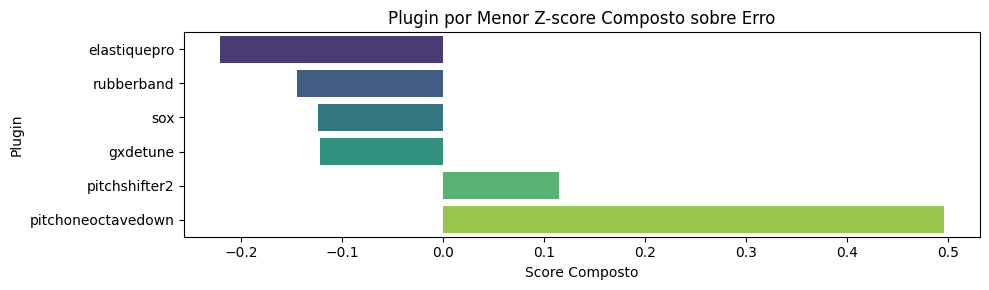

In [ ]:
# Exibir ranking final
plugin_summary_stats = metric_error_per_plugin.groupby('plugin').agg(
    zscore=('zscore', 'mean'),
    avg_error=('avg_error', 'mean'),
    std_error=('std_error', 'mean'),
    metric_count=('metric_count', 'sum')
).sort_values('zscore')  # Lower is better

print("=== Composite plugin ranking (Z-score based) ===")
for i, (pl, row) in enumerate(plugin_summary_stats.iterrows(), 1):
    print(f"{i:2d}. {pl:15s} → score = {row['zscore']:.3f} | avg = {row['avg_error']:.6f}, std = {row['std_error']:.6f}, n = {int(row['metric_count'])}")
best_plugin = plugin_summary_stats.index[0]
print(f"\n🏆 Best plugin (composite score): {best_plugin} → score = {plugin_summary_stats.iloc[0]['zscore']:.3f}")

# === Gráfico de barras com score composto ===
plt.figure(figsize=(10, 3))
sns.barplot(
    data=plugin_summary_stats.reset_index().sort_values('zscore', ascending=True),
    x='zscore', y='plugin',
    hue='plugin',
    palette='viridis',
    orient='h',
    legend=False
)
plt.title('Plugin por Menor Z-score Composto sobre Erro')
plt.xlabel('Score Composto')
plt.ylabel('Plugin')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'composite_score_ranking.png'))
plt.show()


In [ ]:
!zip -r /content/dataset_out.zip /content/dataset/

updating: content/dataset/ (stored 0%)
updating: content/dataset/input/ (stored 0%)
updating: content/dataset/input/E.wav (deflated 12%)
updating: content/dataset/input/G.wav (deflated 9%)
updating: content/dataset/input/A.wav (deflated 9%)
updating: content/dataset/input/C.wav (deflated 13%)
updating: content/dataset/input/D.wav (deflated 13%)
updating: content/dataset/input/F.wav (deflated 10%)
updating: content/dataset/input/B.wav (deflated 11%)
updating: content/dataset/spectrograms/ (stored 0%)
updating: content/dataset/spectrograms/B_pitchoneoctavedown_all_ratios.png (deflated 6%)
updating: content/dataset/spectrograms/F_elastiquepro_all_ratios.png (deflated 2%)
updating: content/dataset/spectrograms/C_elastiquepro_all_ratios.png (deflated 2%)
updating: content/dataset/spectrograms/G_elastiquepro_all_ratios.png (deflated 2%)
updating: content/dataset/spectrograms/C_rubberband_all_ratios.png (deflated 2%)
updating: content/dataset/spectrograms/E_gxdetune_all_ratios.png (deflated 2